In [1]:
from brian2 import *
from matplotlib.pyplot import *

In [2]:
20*volt

20. * volt

# single neuron

In [3]:
tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

In Python, the notation `'''` is used to begin and end a multi-line string. So the equations are just a string with one line per equation. The equations are formatted with standard mathematical notation, with one addition. At the end of a line you write `: unit` where `unit` is the SI unit of that variable. Note that this is not the unit of the two sides of the equation (which would be `1/second`), but the unit of the variable defined by the equation, i.e. in this case `𝑣`.

In [4]:
G = NeuronGroup(1, eqs)

In Brian, you only create groups of neurons, using the class `NeuronGroup`. The first two arguments when you create one of these objects are the number of neurons (in this case, 1) and the defining differential equations.  
If we didn't have a variable `tau`:  
An error is raised, but why? The reason is that the differential equation is now dimensionally inconsistent. The left hand side `dv/dt` has units of `1/second` but the right hand side `1-v` is dimensionless. People often find this behaviour of Brian confusing because this sort of equation is very common in mathematics. However, for quantities with physical dimensions it is incorrect because the results would change depending on the unit you measured it in. For time, if you measured it in seconds the same equation would behave differently to how it would if you measured time in milliseconds. To avoid this, we insist that you always specify dimensionally consistent equations.

In [6]:
run(100*ms)

INFO message is harmless

In [7]:
G = NeuronGroup(1, eqs, method='exact')
print('Before v = %s' % G.v[0])
# runs the simulation for 100 ms
run(100*ms)
print('After v = %s' % G.v[0])

Before v = 0.0
After v = 0.9999546000702376


By default, all variables start with the value 0. Since the differential equation is `dv/dt=(1-v)/tau` we would expect after a while that v would tend towards the value 1, which is just what we see. Specifically, we’d expect `v` to have the value `1-exp(-t/tau)`.

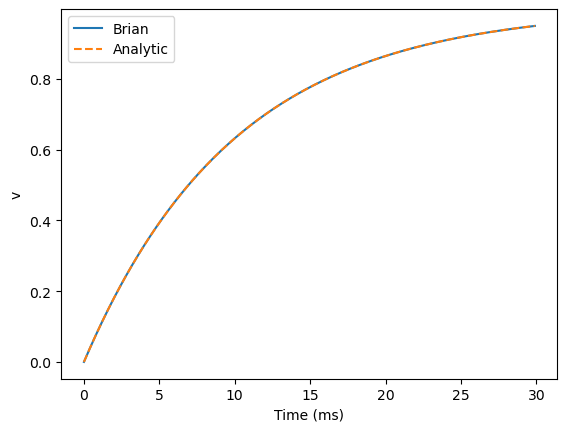

In [16]:
G = NeuronGroup(1, eqs, method='exact')
# StateMonitor: record the values of a neuron variable while the simulation runs 
# record=0: record all values for neuron 0 
# if it's a large simulation, it uses too much RAM to record the values of all neurons 
M = StateMonitor(G, 'v', record=0)

run(30*ms)

plot(M.t/ms, M.v[0], 'C0', label='Brian')
plot(M.t/ms, 1-exp(-M.t/tau), 'C1--',label='Analytic')
xlabel('Time (ms)')
ylabel('v')
legend();

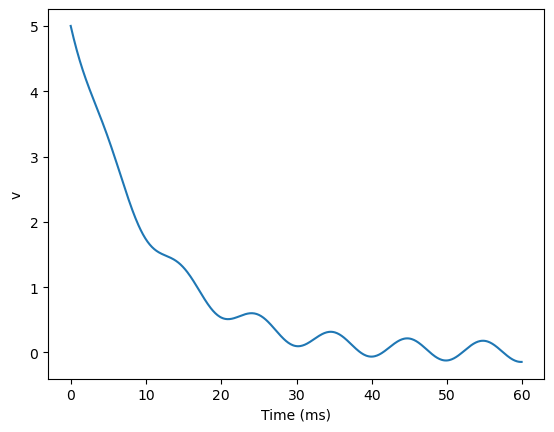

In [17]:
# changing parameters 
tau = 10*ms
eqs = '''
dv/dt = (sin(2*pi*100*Hz*t)-v)/tau : 1
'''

# Change to Euler method because exact integrator doesn't work here
G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, 'v', record=0)

G.v = 5 # initial value

run(60*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

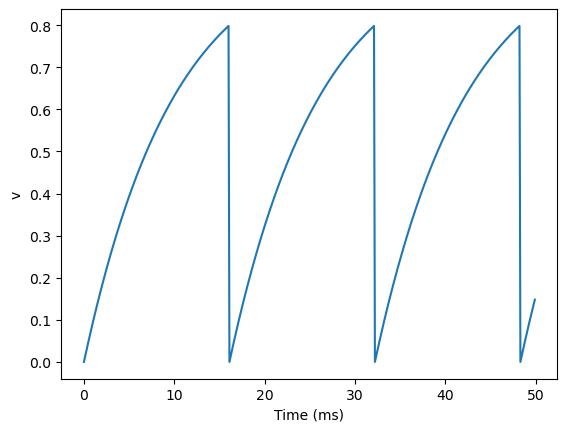

In [19]:
# with spikes 
tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

In [21]:
# spike monitors 
start_scope()
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

spikemon = SpikeMonitor(G)

run(50*ms)

print('Spike times: %s' % spikemon.t[:])

Spike times: [16.  32.1 48.2] ms


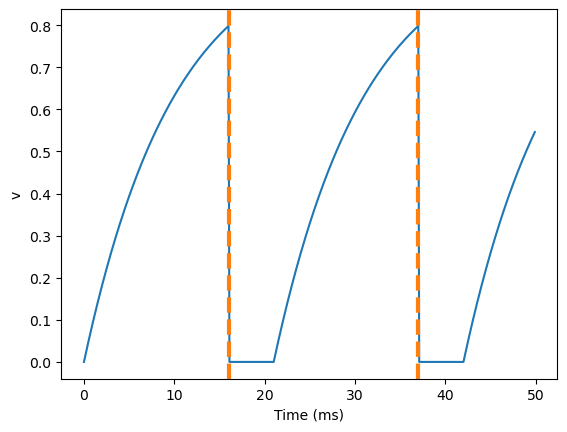

In [23]:
# refractory period 
start_scope()

tau = 10*ms
#*** note the '(unless refractory)' part: this is to make v stay constant during the refractory period 
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

Spike times: [ 8. 23. 38.] ms


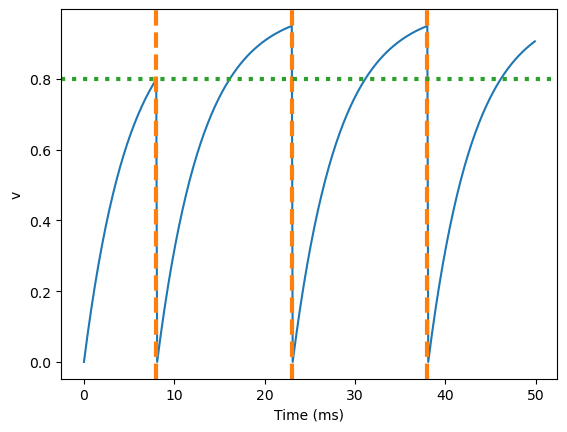

In [26]:
# if you didn't include '(unless refractory)': 
start_scope()

tau = 5*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=15*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
axhline(0.8, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('v')
print("Spike times: %s" % spikemon.t[:])

The behaviour for the first spike is the same: `v` rises to 0.8 and then the neuron fires a spike at time 8 ms before immediately resetting to 0. Since the refractory period is now 15 ms this means that the neuron won’t be able to spike again until time 8 + 15 = 23 ms. Immediately after the first spike, the value of `v` now instantly starts to rise because we didn’t specify `(unless refractory)` in the definition of `dv/dt`. However, once it reaches the value 0.8 (the dashed green line) at time roughly 8 ms it doesn’t fire a spike even though the threshold is `v>0.8`. This is because the neuron is still refractory until time 23 ms, at which point it fires a spike.

# multiple neurons

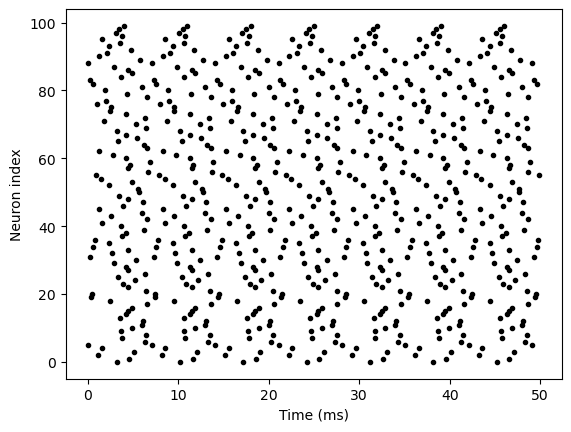

In [27]:
start_scope()

N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
# initiate each neuron with a different uniform random value between 0 and 1 
G.v = 'rand()'

spikemon = SpikeMonitor(G)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

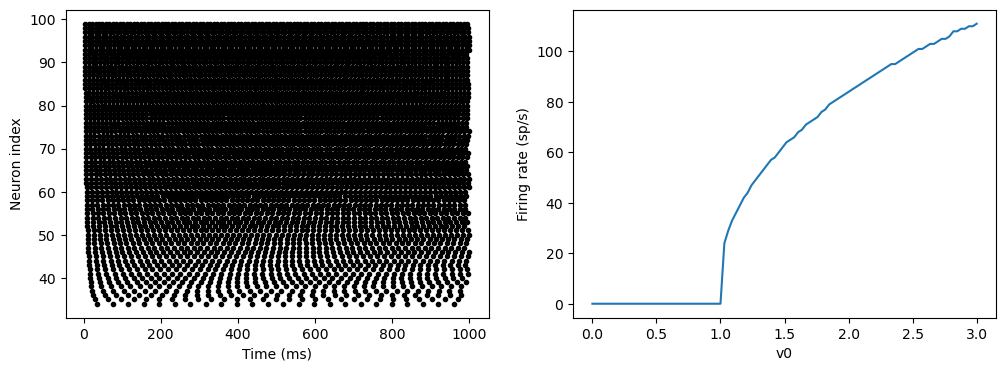

In [30]:
# per-neuron parameters that don't have a differential equation attached to them 
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

# "v0 : 1": declares a new per-neuron parameter v0 with units 1 (i.e. dimensionless) 
eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

## stochastic neurons

In Brian, we can do this by using the symbol `xi` in differential equations. Strictly speaking, this symbol is a “stochastic differential” but you can sort of thinking of it as just a Gaussian random variable with mean 0 and standard deviation 1. We do have to take into account the way stochastic differentials scale with time, which is why we multiply it by `tau**-0.5` in the equations below (see a textbook on stochastic differential equations for more details). Note that we also changed the `method` keyword argument to use `'euler'` (which stands for the Euler-Maruyama method); the `'exact'` method that we used earlier is not applicable to stochastic differential equations.

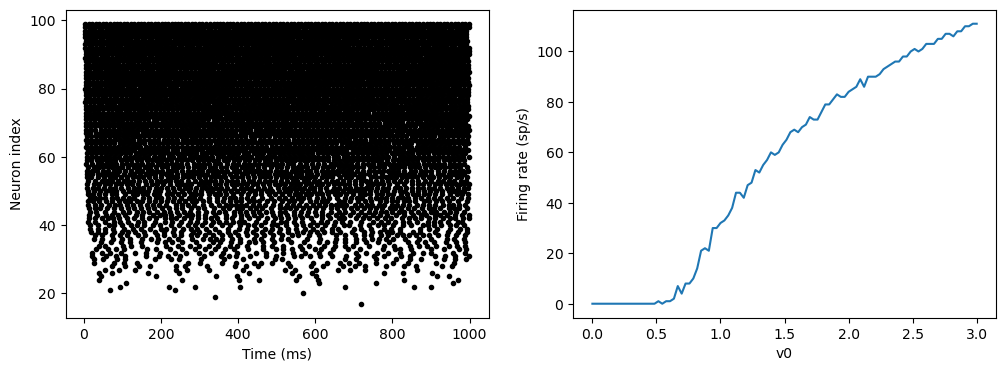

In [31]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms
sigma = 0.2

eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

# play with it

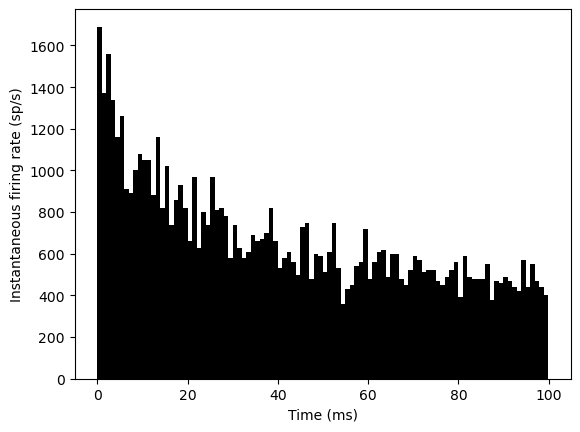

In [11]:
start_scope()

N = 1000
tau = 10*ms
# resting potential 
vr = -70*mV
# initial potential 
vt0 = -50*mV
 # chang in initial potential 
delta_vt0 = 5*mV
tau_t = 100*ms
# variance 
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 100*ms

# vt approaches vt0 with time constant tau_t 
eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

# threshold to firing changes when there's a spike 
reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
spikemon = SpikeMonitor(G)
statemonv = StateMonitor(G, 'v', record=0)
statemonvt = StateMonitor(G, 'vt', record = 0)

# random initial value 
G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=list(ones(len(spikemon))/(N*defaultclock.dt)))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)');

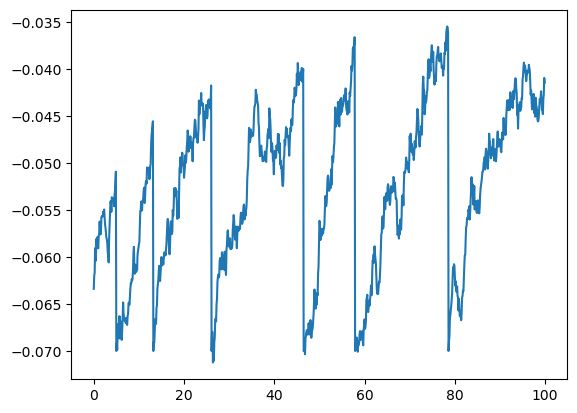

In [17]:
plot(statemonv.t/ms, statemonv.v[0])

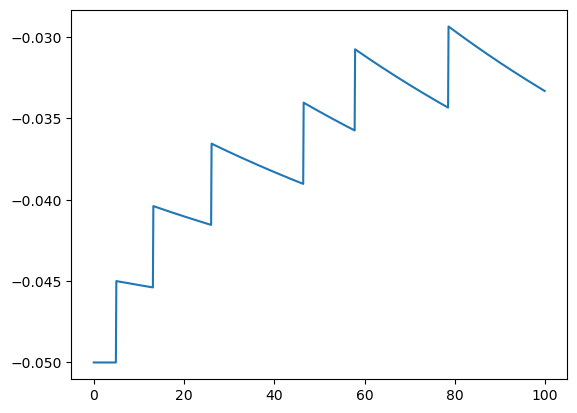

In [20]:
plot(statemonvt.t/ms, statemonvt.vt[0])